In [45]:
import os
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### IMDb Non-Commercial Datasets

This is a non-commercial dataset, can be used for personal and non-commercial purposes: found here https://developer.imdb.com/non-commercial-datasets/

The dataset files can be accessed and downloaded from https://datasets.imdbws.com/. The data is refreshed daily. `TODO:` run automated ETL for this

Dataset details: - Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A '\N' is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows:


In [2]:
# Define the target directory relative to the notebook location, and create if it doesn't exist
output_dir = Path('datasets/imdb_non_commercial')
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# List of dataset URLs from the IMDB website
urls = [
    'https://datasets.imdbws.com/name.basics.tsv.gz',
    'https://datasets.imdbws.com/title.akas.tsv.gz',
    'https://datasets.imdbws.com/title.basics.tsv.gz',
    'https://datasets.imdbws.com/title.crew.tsv.gz',
    'https://datasets.imdbws.com/title.episode.tsv.gz',
    'https://datasets.imdbws.com/title.principals.tsv.gz',
    'https://datasets.imdbws.com/title.ratings.tsv.gz'
]

Download all datasets. Note these will be zipped

In [4]:
for url in urls:
    # Extract filename from URL
    filename = url.split('/')[-1]
    filepath = output_dir / filename
    
    print(f"Downloading {filename}...")
    
    # Download the file; raise an error for bad status codes
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    # Save to file
    with open(filepath, 'wb') as f:
        # 8kb in memory at a time (memory efficiency)
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    print(f"Saved to {filepath}")

print("\nAll datasets downloaded successfully!")

Saved to datasets/imdb_non_commercial/name.basics.tsv.gz
Saved to datasets/imdb_non_commercial/title.akas.tsv.gz
Saved to datasets/imdb_non_commercial/title.basics.tsv.gz
Saved to datasets/imdb_non_commercial/title.crew.tsv.gz
Saved to datasets/imdb_non_commercial/title.episode.tsv.gz
Saved to datasets/imdb_non_commercial/title.principals.tsv.gz
Saved to datasets/imdb_non_commercial/title.ratings.tsv.gz

All datasets downloaded successfully!


### Dataset exploration

In [15]:
def read_sample_df(data_path, sep='\t', compression='gzip', sample=True, top_rows=10000):
    if sample:
        # read first rows for review
        df_sample= pd.read_csv(
            data_path,
            sep=sep,
            compression=compression,
            nrows=top_rows
        )
    else:
        df_sample= pd.read_csv(
            data_path,
            sep=sep,
            compression=compression
        )
    return df_sample

In [17]:
name_basics_sample = read_sample_df('datasets/imdb_non_commercial/name.basics.tsv.gz', sample=True)
title_akas_sample = read_sample_df('datasets/imdb_non_commercial/title.akas.tsv.gz', sample=True)
title_basics_sample = read_sample_df('datasets/imdb_non_commercial/title.basics.tsv.gz', sample=True)
title_crew_sample = read_sample_df('datasets/imdb_non_commercial/title.crew.tsv.gz', sample=True)
title_episode_sample = read_sample_df('datasets/imdb_non_commercial/title.episode.tsv.gz', sample=True)
title_principals_sample = read_sample_df('datasets/imdb_non_commercial/title.principals.tsv.gz', sample=True)
title_ratings_sample = read_sample_df('datasets/imdb_non_commercial/title.ratings.tsv.gz', sample=True)

### Review Dataset: Name basics (sample)

In [18]:
name_basics_sample.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,miscellaneous","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0083922,tt0050976"


In [24]:
name_basics_sample.nunique()

nconst               10000
primaryName           9884
birthYear              165
deathYear              136
primaryProfession     1693
knownForTitles        9893
dtype: int64

Do we have a duplicate problem here?

In [22]:
name_basics_sample['primaryName'].value_counts()

primaryName
David Abbott                     4
Linus Aaberg                     4
John Foster                      3
Carlos Acosta                    3
Eric Abrahamson                  3
                                ..
Marcos Eduardo Acosta Aldrete    1
Damián Acosta Esparza            1
Ricardo Acosta Fernández         1
Luis Acosta García               1
Marlon Brando                    1
Name: count, Length: 9884, dtype: int64

In [25]:
name_basics_sample[name_basics_sample['primaryName'] == 'Linus Aaberg']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
7273,nm0007313,Linus Aaberg,\N,\N,actor,tt0012043
7274,nm0007314,Linus Aaberg,1977,\N,actor,"tt0113576,tt0103421"
7275,nm0007315,Linus Aaberg,\N,\N,art_director,\N
7276,nm0007316,Linus Aaberg,\N,\N,special_effects,\N


Should some of these entities be merged? e.g. nm0007313 and nm0007314, both actors?

In [26]:
name_basics_sample[name_basics_sample['primaryName'] == 'David Abbott']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
6854,nm0006881,David Abbott,\N,\N,"make_up_department,miscellaneous","tt0106598,tt0133152,tt0118928,tt0160127"
7889,nm0007955,David Abbott,\N,\N,"art_department,camera_department","tt0332452,tt0120616,tt0448134,tt10548174"
7890,nm0007956,David Abbott,\N,\N,actor,"tt0280462,tt0460681,tt0491522,tt0997278"
7891,nm0007957,David Abbott,1965,\N,"actor,archive_footage","tt0185130,tt0251469,tt0222648,tt1505434"


In [27]:
name_basics_sample[name_basics_sample['primaryName'] == 'Eric Abrahamson']

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
7069,nm0007097,Eric Abrahamson,\N,\N,"producer,assistant_director,miscellaneous","tt0286716,tt0209475,tt0189810,tt0111517"
8933,nm0009048,Eric Abrahamson,\N,\N,"actor,camera_department","tt0125060,tt0109933"
8934,nm0009049,Eric Abrahamson,\N,\N,miscellaneous,tt0110153


### Review Dataset: Title akas (sample)

In [29]:
title_akas_sample.head(10)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita,\N,\N,original,\N,1
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita,US,\N,imdbDisplay,\N,0
3,tt0000001,4,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
4,tt0000001,5,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
5,tt0000001,6,Карменсита,RU,\N,imdbDisplay,\N,0
6,tt0000001,7,Карменсіта,UA,\N,imdbDisplay,\N,0
7,tt0000001,8,カルメンチータ,JP,ja,imdbDisplay,\N,0
8,tt0000002,1,Le clown et ses chiens,\N,\N,original,\N,1
9,tt0000002,2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0


In [30]:
title_akas_sample.nunique()

titleId            3193
ordering             50
title              6267
region               54
language             19
types                 9
attributes           38
isOriginalTitle       2
dtype: int64

In [31]:
title_akas_sample['types'].unique()

array(['original', '\\N', 'imdbDisplay', 'alternative', 'festival', 'dvd',
       'working', 'tv', 'video'], dtype=object)

In [37]:
title_akas_sample['attributes'].unique()[:10]

array(['\\N', 'literal title', 'literal English title',
       'informal alternative title', 'promotional title',
       'complete title', 'reissue title', 'informal title',
       'premiere title', 'short title'], dtype=object)

In [43]:
title_akas_sample['titleId'].nunique()

3193

Interesting to see we have alternative naming for each title in the dataset.

### Review Dataset: Title basics (sample)

In [9]:
title_basics_sample.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


In [46]:
title_basics_sample['titleType'].value_counts()

titleType
short    5791
movie    4209
Name: count, dtype: int64

Check stats for runtimeMinutes

In [47]:
title_basics_sample['runtimeMinutes'].describe()

count     10000
unique      156
top          \N
freq       4875
Name: runtimeMinutes, dtype: object

Looks like we have some missing data here (substituted with '\N' in the dataset). Replace with NaN and convert to numeric

In [48]:
title_basics_sample['runtimeMinutesNumeric'] = title_basics_sample['runtimeMinutes'].replace('\\N', None)
title_basics_sample['runtimeMinutesNumeric'] = pd.to_numeric(title_basics_sample['runtimeMinutesNumeric'])

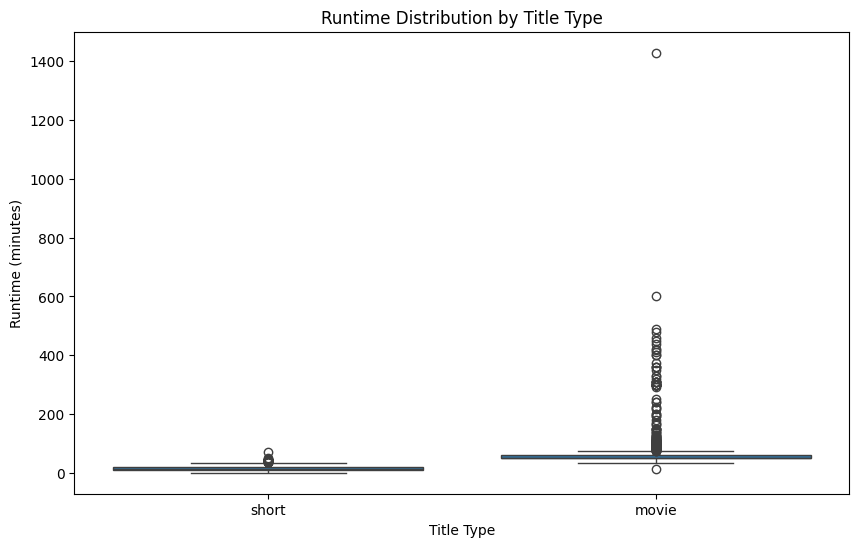

In [55]:
# Plot runtime distribution by title type - Box plot only
plt.figure(figsize=(10, 6))
sns.boxplot(data=title_basics_sample, x='titleType', y='runtimeMinutesNumeric')
plt.title('Runtime Distribution by Title Type')
plt.xlabel('Title Type')
plt.ylabel('Runtime (minutes)')
plt.show()

In [57]:
title_basics_sample[title_basics_sample['titleType'] == 'short']['runtimeMinutesNumeric'].describe()

count    2574.000000
mean       15.109557
std         9.796116
min         1.000000
25%        10.000000
50%        12.000000
75%        20.000000
max        70.000000
Name: runtimeMinutesNumeric, dtype: float64

In [58]:
title_basics_sample[title_basics_sample['titleType'] == 'movie']['runtimeMinutesNumeric'].describe()

count    2551.000000
mean       61.852215
std        48.601643
min        13.000000
25%        50.000000
50%        50.000000
75%        60.000000
max      1428.000000
Name: runtimeMinutesNumeric, dtype: float64

### Review Dataset: Title Crew (sample)

In [63]:
title_crew_sample.head(10)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,nm0721526
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
5,tt0000006,nm0005690,\N
6,tt0000007,"nm0005690,nm0374658",\N
7,tt0000008,nm0005690,\N
8,tt0000009,nm0085156,nm0085156
9,tt0000010,nm0525910,\N


Directors and writers for movies. Each title may have multiple, comma separated directors or writers

In [64]:
def count_people(value):
    """Count the number of people in a comma-separated string"""
    if pd.isna(value) or value == '\\N':
        return 0
    return len(value.split(','))

In [65]:
# Apply the function to create new columns
title_crew_sample['num_directors'] = title_crew_sample['directors'].apply(count_people)
title_crew_sample['num_writers'] = title_crew_sample['writers'].apply(count_people)

In [67]:
title_crew_sample.head(10)

,tconst,directors,writers,num_directors,num_writers
0,tt0000001,nm0005690,\N,1,0
1,tt0000002,nm0721526,\N,1,0
2,tt0000003,nm0721526,nm0721526,1,1
3,tt0000004,nm0721526,\N,1,0
4,tt0000005,nm0005690,\N,1,0
5,tt0000006,nm0005690,\N,1,0
6,tt0000007,"nm0005690,nm0374658",\N,2,0
7,tt0000008,nm0005690,\N,1,0
8,tt0000009,nm0085156,nm0085156,1,1
9,tt0000010,nm0525910,\N,1,0


In [69]:
print("Distribution of number of directors per title:")
print(title_crew_sample['num_directors'].value_counts().sort_index())
print("\n" + "="*50 + "\n")
print("Distribution of number of writers per title:")
print(title_crew_sample['num_writers'].value_counts().sort_index())

Distribution of number of directors per title:
num_directors
0     734
1    8627
2     591
3      41
4       5
6       1
7       1
Name: count, dtype: int64


Distribution of number of writers per title:
num_writers
0     2961
1     4349
2     2104
3      484
4       84
5       13
6        3
7        1
19       1
Name: count, dtype: int64


### Review Dataset: Title Episode (sample)

In [70]:
title_episode_sample.head()

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0031458,tt32857063,\N,\N
1,tt0041951,tt0041038,1,9
2,tt0042816,tt0989125,1,17
3,tt0042889,tt0989125,\N,\N
4,tt0043426,tt0040051,3,42


In [71]:
title_episode_sample.nunique()

tconst           10000
parentTconst      1589
seasonNumber        66
episodeNumber      573
dtype: int64

### Review Dataset: Title Principals (sample)

In [72]:
title_principals_sample.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0005690,producer,producer,\N
3,tt0000001,4,nm0374658,cinematographer,director of photography,\N
4,tt0000002,1,nm0721526,director,\N,\N


In [73]:
title_principals_sample['category'].value_counts()

category
actor                  3917
actress                2064
director               1647
writer                  913
cinematographer         863
producer                489
self                     49
composer                 26
production_designer      25
editor                    7
Name: count, dtype: int64

In [74]:
title_principals_sample[title_principals_sample['category'] == 'actor']

,tconst,ordering,nconst,category,job,characters
14,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]"
15,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]"
17,tt0000007,1,nm0179163,actor,\N,\N
18,tt0000007,2,nm0183947,actor,\N,\N
24,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]"
...,...,...,...,...,...,...
9992,tt0001733,6,nm0334918,actor,\N,"[""The Doctor""]"
9993,tt0001733,7,nm0733176,actor,\N,"[""The Butler""]"
9994,tt0001733,8,nm0125164,actor,\N,"[""One of the Father's Friends""]"
9995,tt0001733,9,nm0187981,actor,\N,\N


### Review Dataset: Title Ratings (sample)

In [75]:
title_ratings_sample.head(10)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2183
1,tt0000002,5.5,304
2,tt0000003,6.4,2263
3,tt0000004,5.2,195
4,tt0000005,6.2,3006
5,tt0000006,5.0,220
6,tt0000007,5.3,932
7,tt0000008,5.3,2355
8,tt0000009,5.3,231
9,tt0000010,6.8,8137


### Summary: what we could use from this dataset